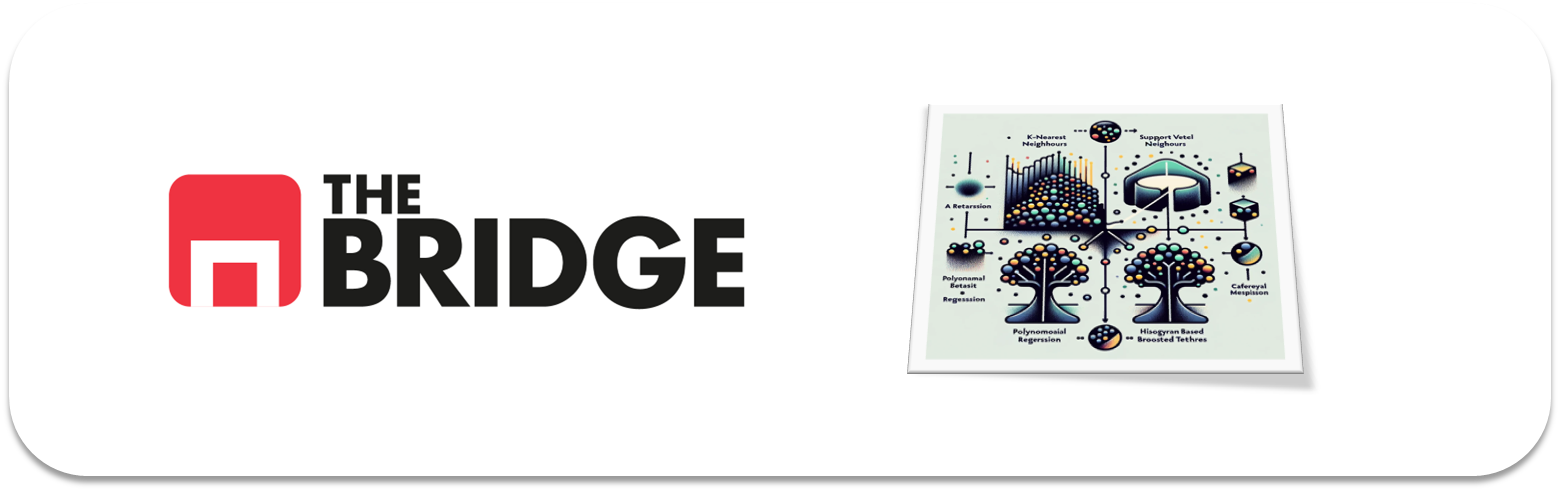

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [50]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [51]:
#df_credit = pd.read_csv("./data/cs-training.csv",index_col=0)
df_credit = pd.read_csv("./data/credit_npo.csv")


In [52]:
df_credit.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
5,0,0.101002,61,0,0.217115,15880.0,5,0,1,0,0.0
6,0,0.222830,60,0,0.907083,1312.0,5,0,0,0,0.0
7,0,0.353443,39,0,0.764309,4000.0,11,0,1,0,2.0
8,0,0.772455,45,0,0.387179,5100.0,5,0,1,0,3.0
9,0,0.116165,44,0,0.160236,10833.0,8,0,1,0,0.0


In [53]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

In [54]:
target="SeriousDlqin2yrs"
features = df_credit.drop(columns=[target]).columns.tolist()

In [55]:
def analisis_missing(df:pd.DataFrame):
# Analisis de "unknown","missing","np.Nan"

    for col in df.columns:
        print(f"Para {col}, unknowns,missings,np.NaN:", end = " ")
        try:
            if not np.issubdtype(df[col].dtype, np.number):
                missings = df[col].value_counts()["unknown"] 
            else:
                missings = df[col].isna().sum()
            
            print(f"{missings}, {round(missings/len(df)*100.0,2)}%")
        except:
            print(0)
    print("-"*100)
    return None

In [56]:
analisis_missing(df_credit)

df_credit.dropna(inplace=True)

analisis_missing(df_credit)


Para SeriousDlqin2yrs, unknowns,missings,np.NaN: 0, 0.0%
Para RevolvingUtilizationOfUnsecuredLines, unknowns,missings,np.NaN: 0, 0.0%
Para age, unknowns,missings,np.NaN: 0, 0.0%
Para NumberOfTime30-59DaysPastDueNotWorse, unknowns,missings,np.NaN: 0, 0.0%
Para DebtRatio, unknowns,missings,np.NaN: 0, 0.0%
Para MonthlyIncome, unknowns,missings,np.NaN: 721, 5.75%
Para NumberOfOpenCreditLinesAndLoans, unknowns,missings,np.NaN: 0, 0.0%
Para NumberOfTimes90DaysLate, unknowns,missings,np.NaN: 0, 0.0%
Para NumberRealEstateLoansOrLines, unknowns,missings,np.NaN: 0, 0.0%
Para NumberOfTime60-89DaysPastDueNotWorse, unknowns,missings,np.NaN: 0, 0.0%
Para NumberOfDependents, unknowns,missings,np.NaN: 177, 1.41%
----------------------------------------------------------------------------------------------------
Para SeriousDlqin2yrs, unknowns,missings,np.NaN: 0, 0.0%
Para RevolvingUtilizationOfUnsecuredLines, unknowns,missings,np.NaN: 0, 0.0%
Para age, unknowns,missings,np.NaN: 0, 0.0%
Para NumberOfTi

### #1.3
Pinta la distribución de frecuencias del target y coméntala

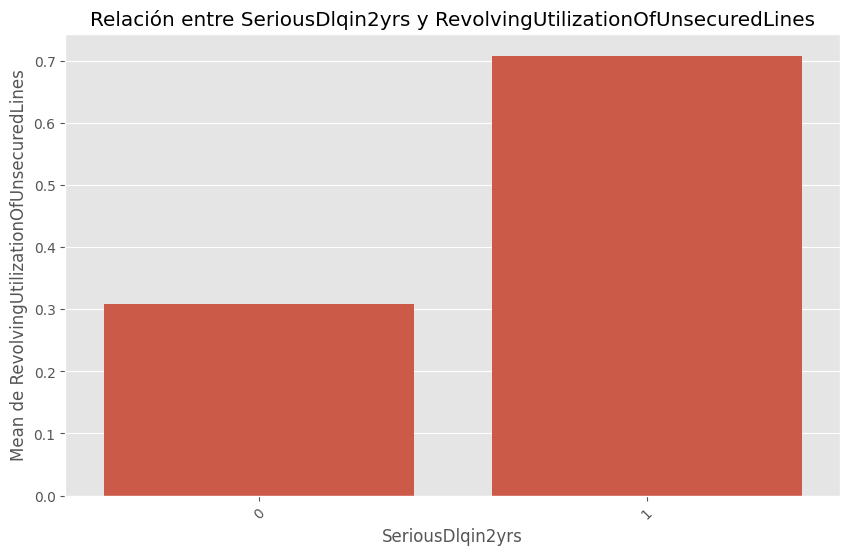

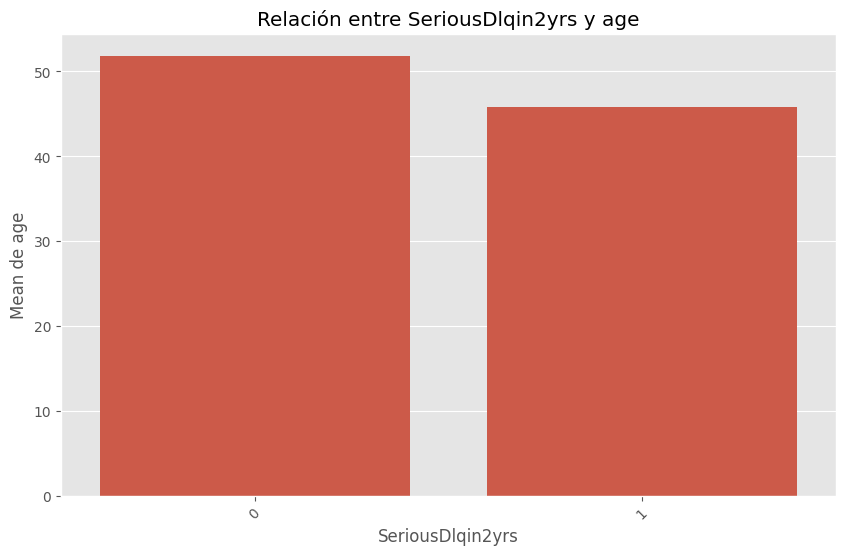

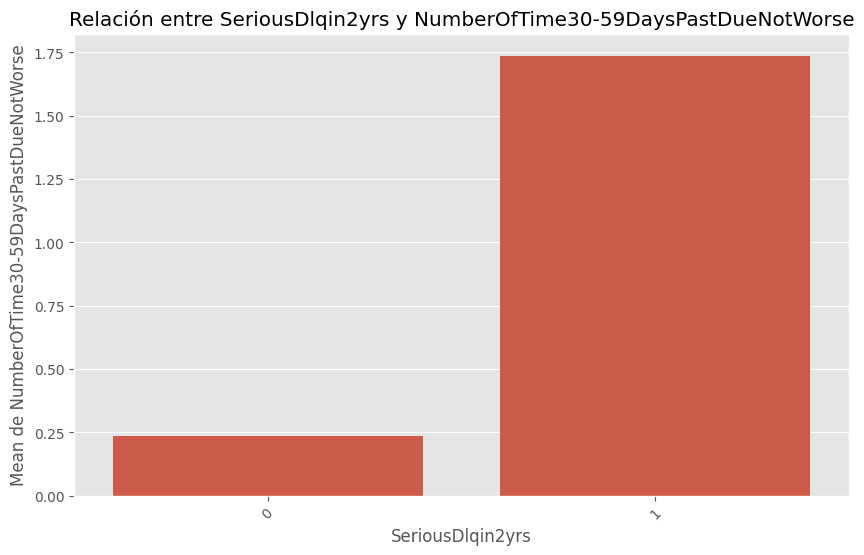

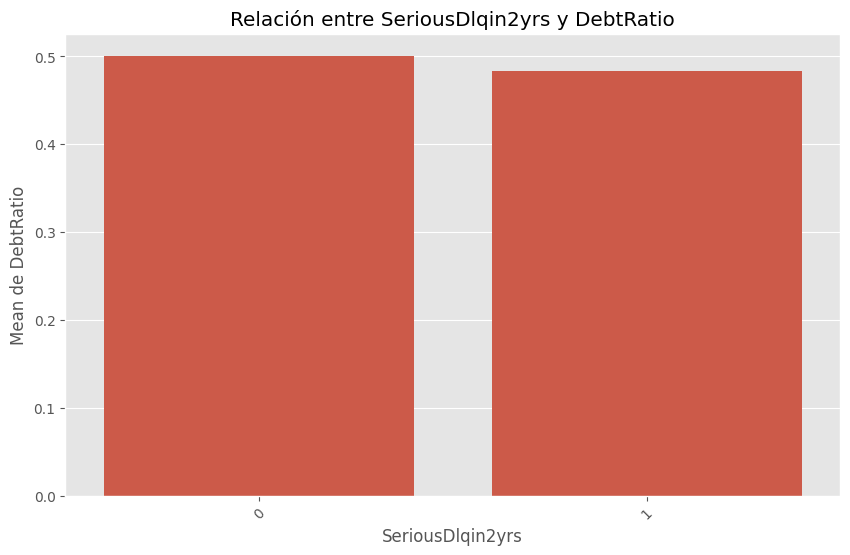

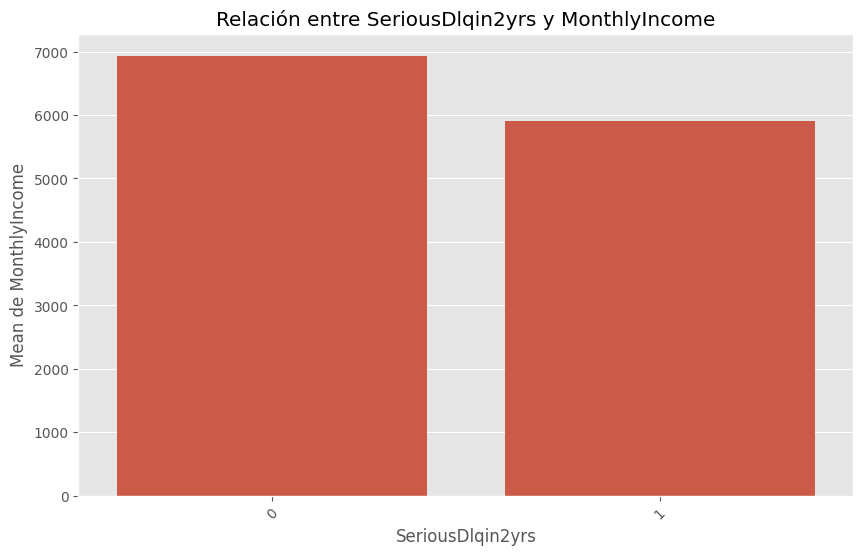

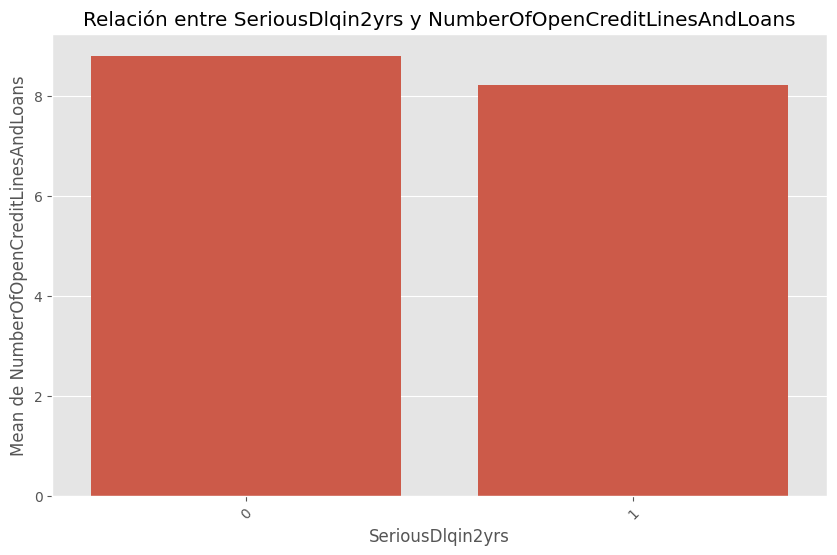

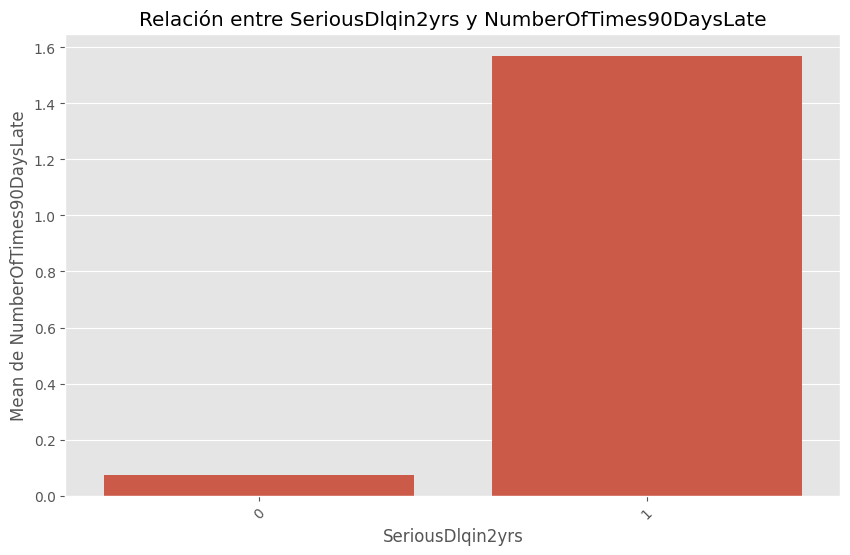

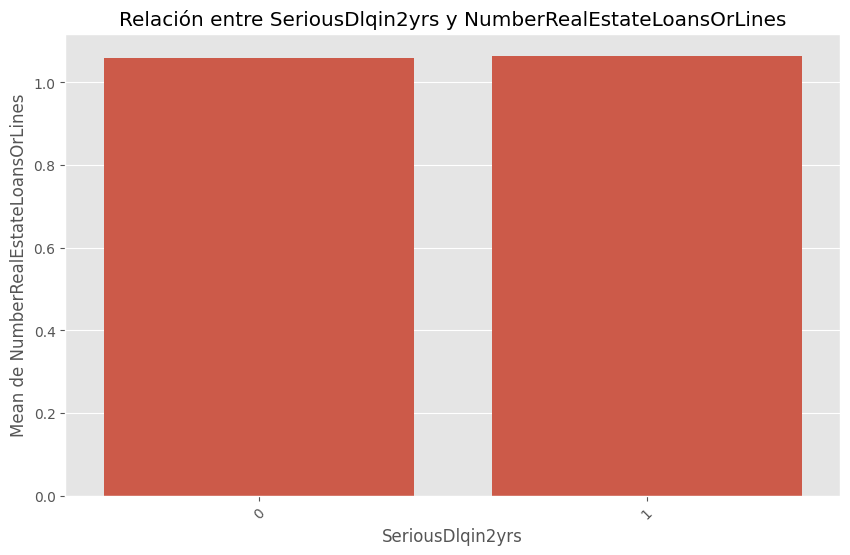

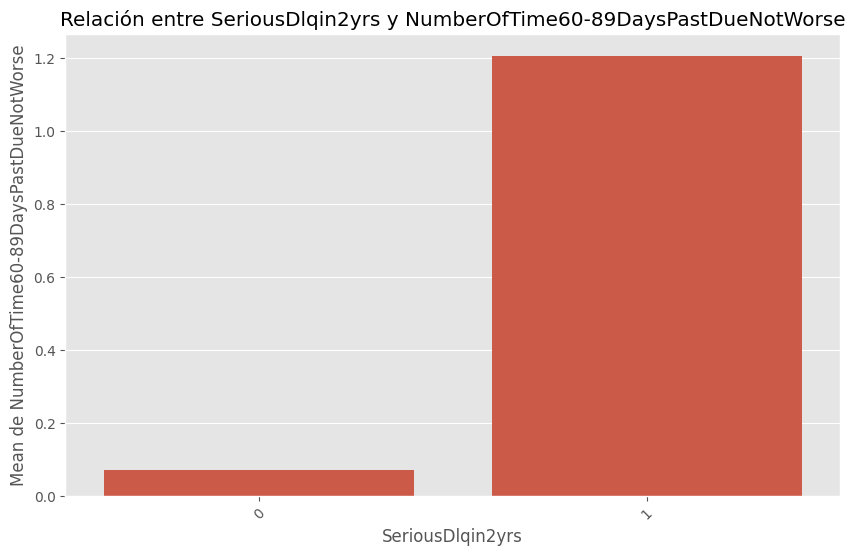

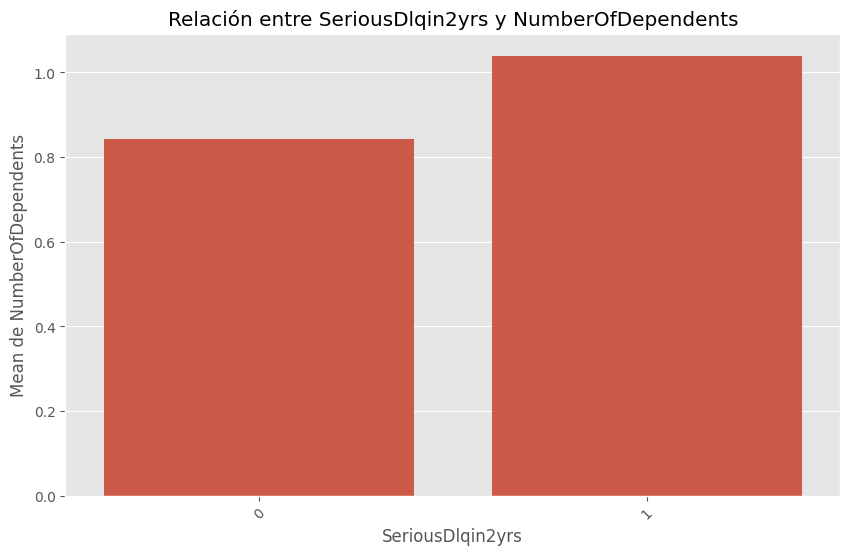

In [8]:
for columna in features:
    bt.plot_categorical_numerical_relationship(df_credit,target,columna)

In [9]:
df_credit.corr()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,0.280350,-0.106076,0.131163,-0.001666,-0.022199,-0.029574,0.132191,0.001321,0.101231,0.043825
RevolvingUtilizationOfUnsecuredLines,0.280350,1.000000,-0.258454,0.108110,0.010778,-0.046920,-0.169089,0.098174,-0.092158,0.075262,0.067975
age,-0.106076,-0.258454,1.000000,-0.034702,-0.008830,0.053273,0.177826,-0.036142,0.071614,-0.028431,-0.211502
NumberOfTime30-59DaysPastDueNotWorse,0.131163,0.108110,-0.034702,1.000000,-0.004600,-0.012814,-0.031861,0.965629,-0.015833,0.971470,-0.004458
DebtRatio,-0.001666,0.010778,-0.008830,-0.004600,1.000000,-0.036568,0.024201,-0.006275,0.029228,-0.005406,0.000053
MonthlyIncome,-0.022199,-0.046920,0.053273,-0.012814,-0.036568,1.000000,0.105096,-0.015646,0.162305,-0.013327,0.075561
NumberOfOpenCreditLinesAndLoans,-0.029574,-0.169089,0.177826,-0.031861,0.024201,0.105096,1.000000,-0.067779,0.427986,-0.052836,0.030446
NumberOfTimes90DaysLate,0.132191,0.098174,-0.036142,0.965629,-0.006275,-0.015646,-0.067779,1.000000,-0.039932,0.983381,-0.009802
NumberRealEstateLoansOrLines,0.001321,-0.092158,0.071614,-0.015833,0.029228,0.162305,0.427986,-0.039932,1.000000,-0.030897,0.115146
NumberOfTime60-89DaysPastDueNotWorse,0.101231,0.075262,-0.028431,0.971470,-0.005406,-0.013327,-0.052836,0.983381,-0.030897,1.000000,-0.013287


In [57]:
df_credit[target].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.929756
1    0.070244
Name: proportion, dtype: float64

In [58]:
features_analysis=["RevolvingUtilizationOfUnsecuredLines","age",
"NumberOfOpenCreditLinesAndLoans",
"NumberOfTime30-59DaysPastDueNotWorse",
"MonthlyIncome",
"NumberOfTimes90DaysLate",
"NumberOfTime60-89DaysPastDueNotWorse"]


Elimino nulos de MonthlyIncome

In [59]:
df_credit_copy = df_credit.copy()

df_credit.dropna(inplace=True)

In [60]:
df_credit

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [61]:
train_set, test_set = train_test_split(df_credit, test_size= 0.2, random_state= 42)

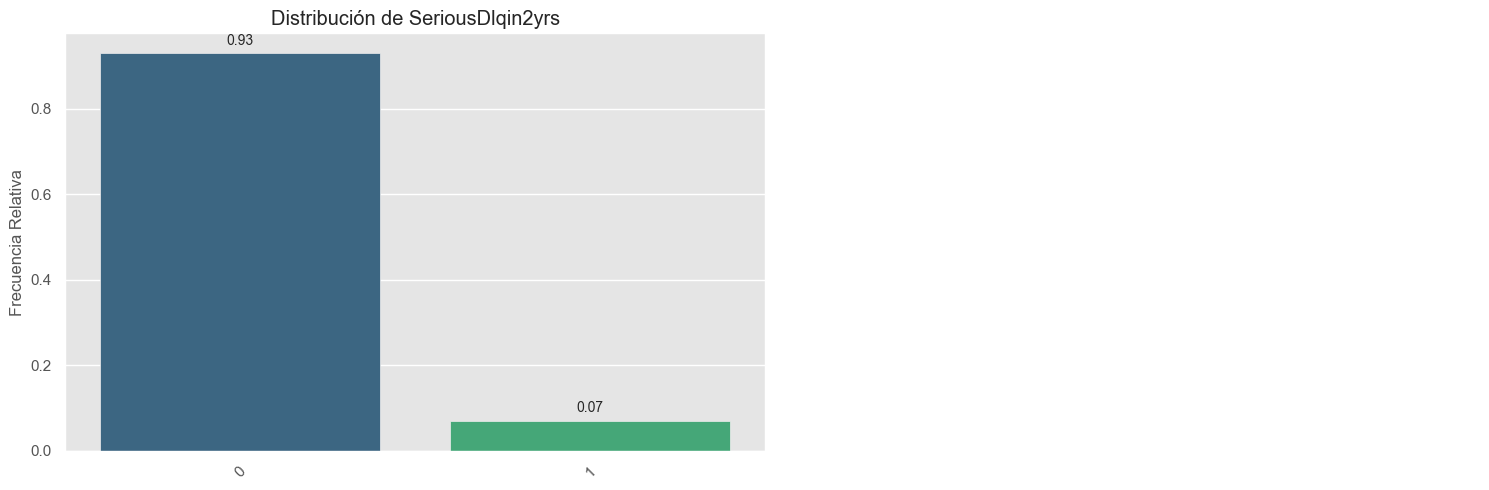

In [62]:
bt.pinta_distribucion_categoricas(train_set, [target], relativa= True, mostrar_valores= True)

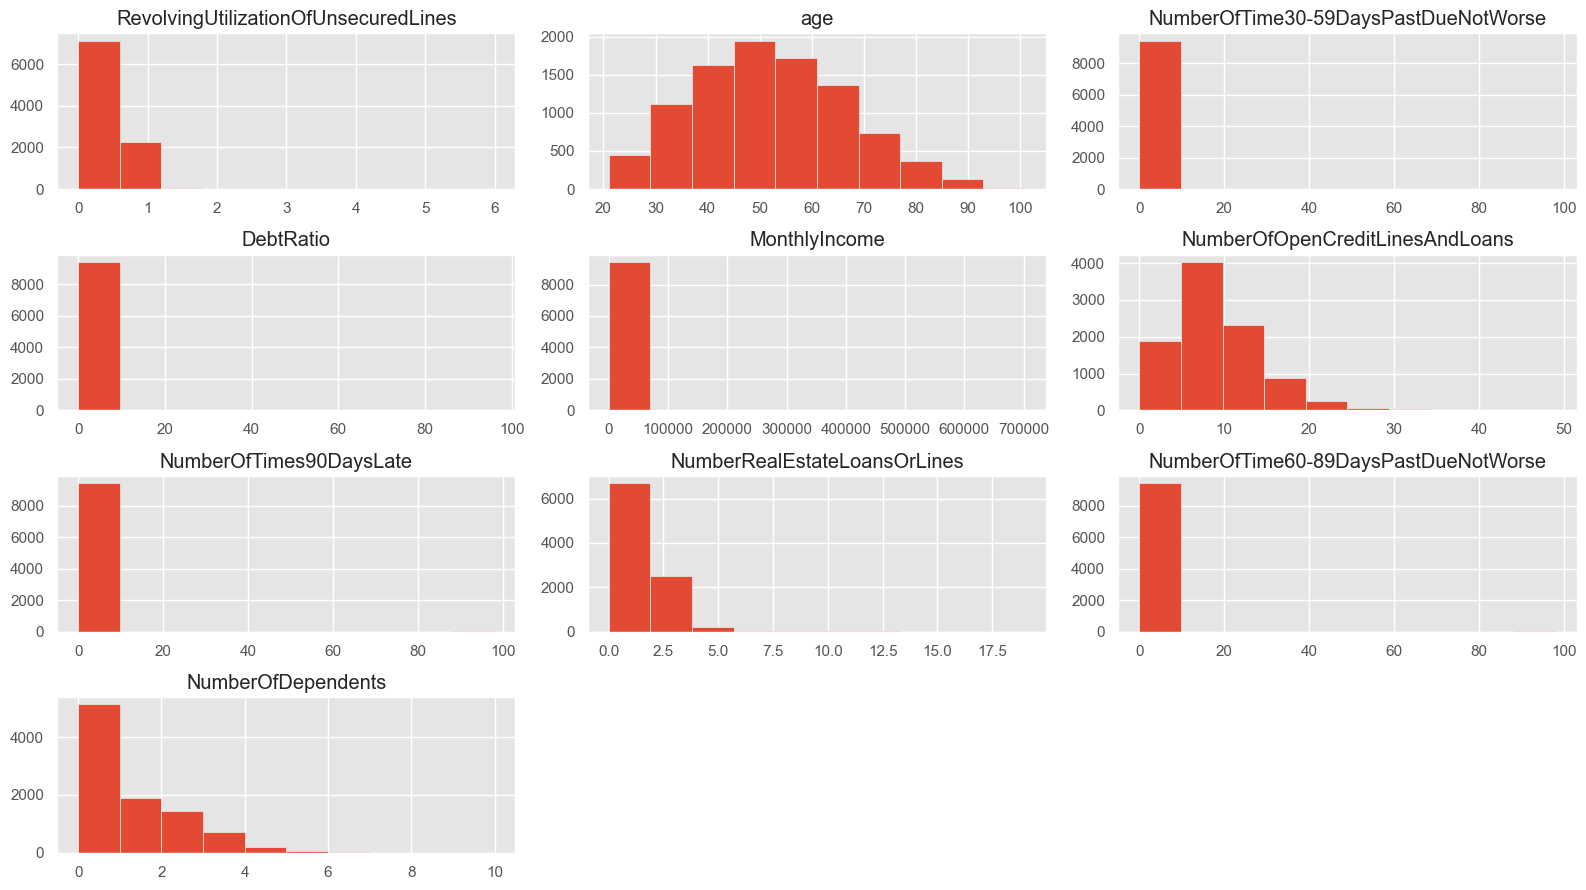

In [63]:
train_set[features].hist()
plt.tight_layout()

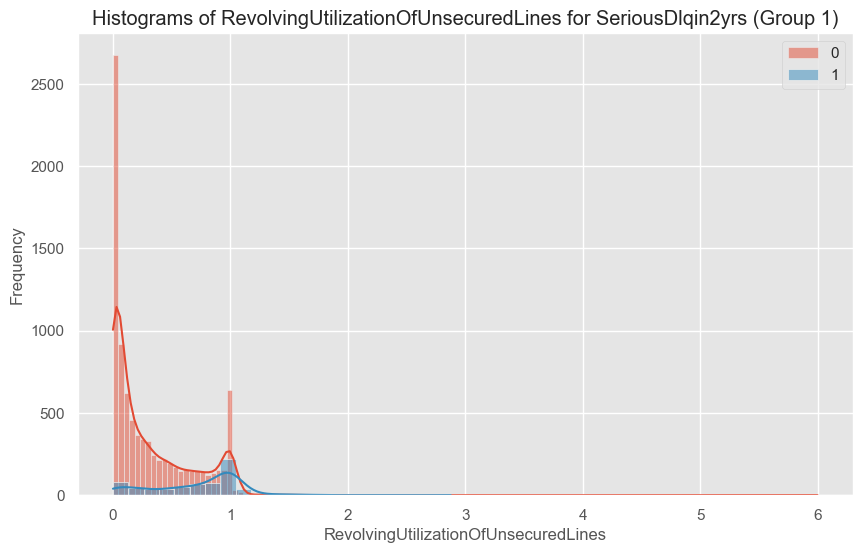

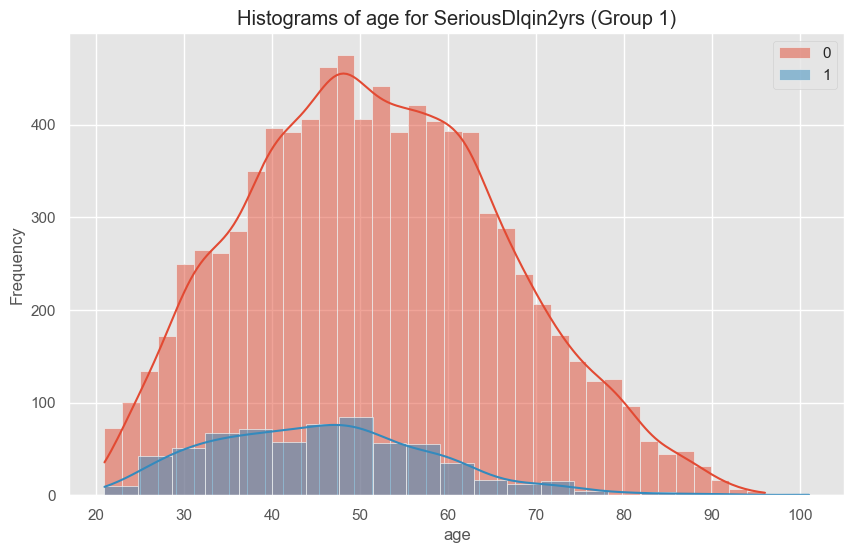

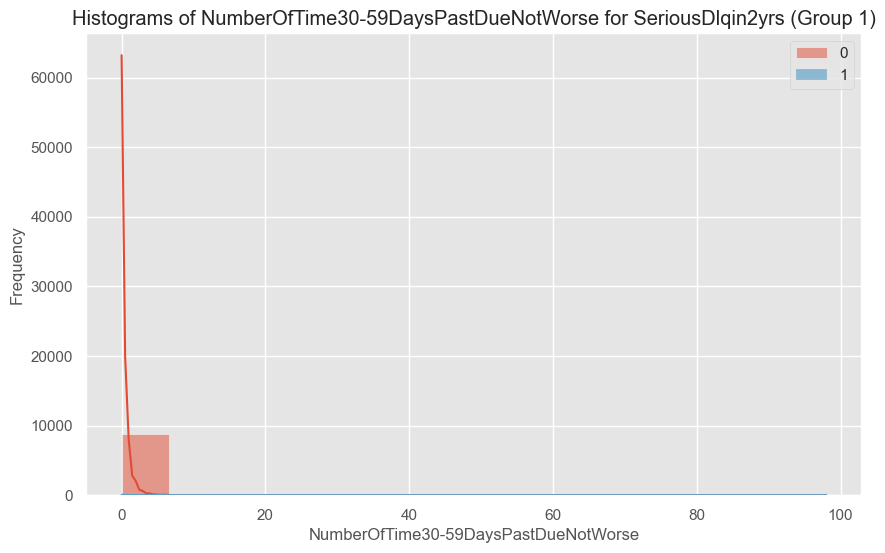

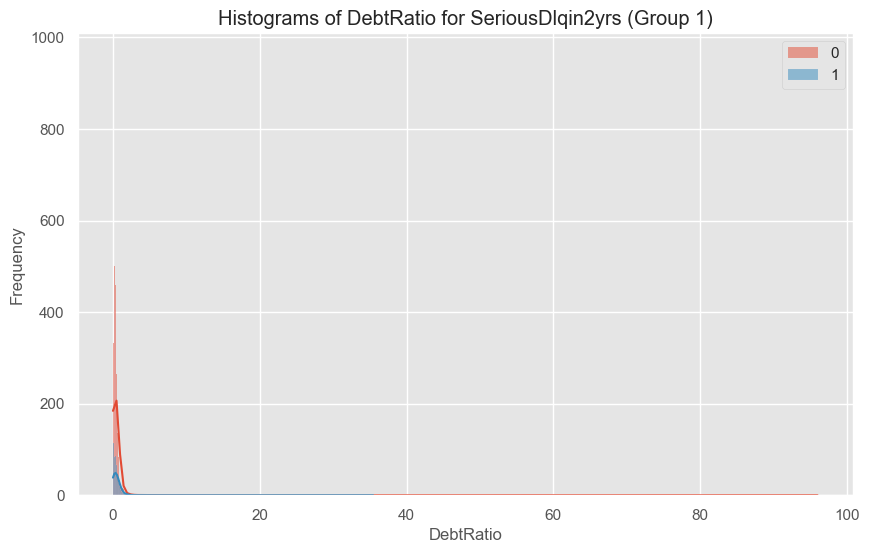

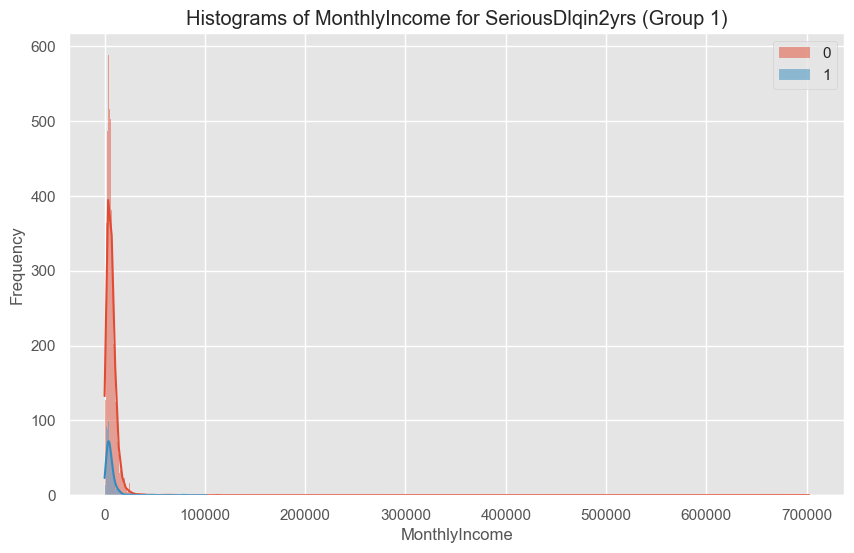

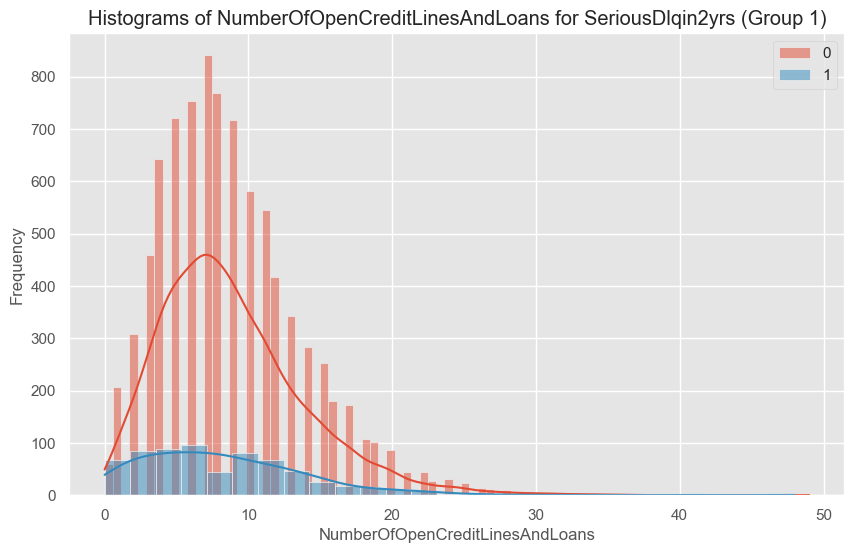

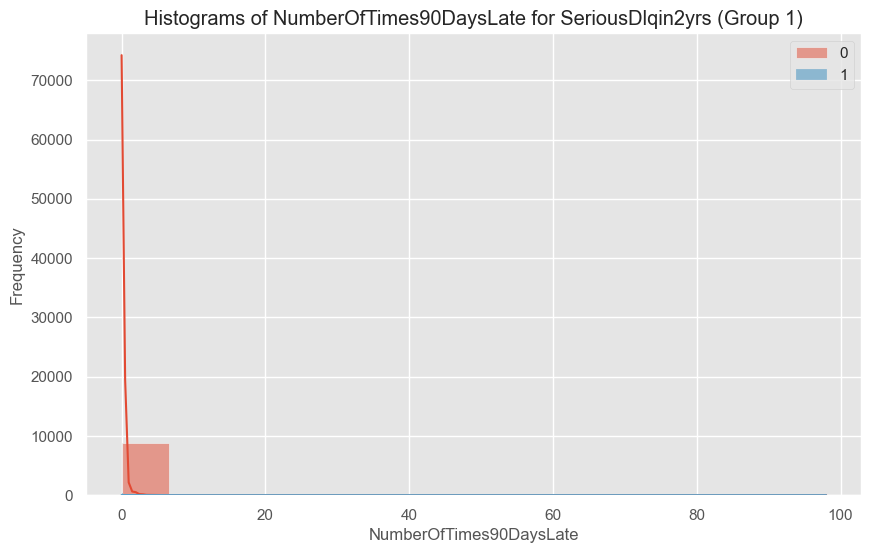

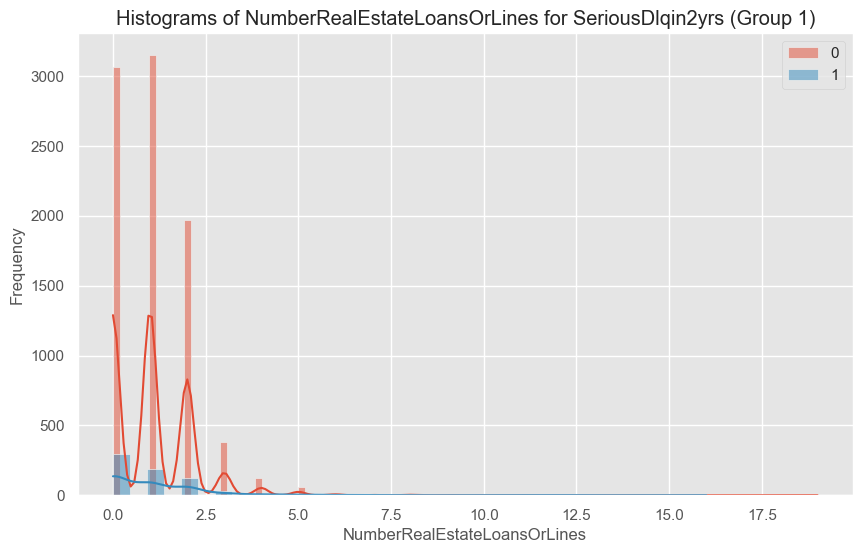

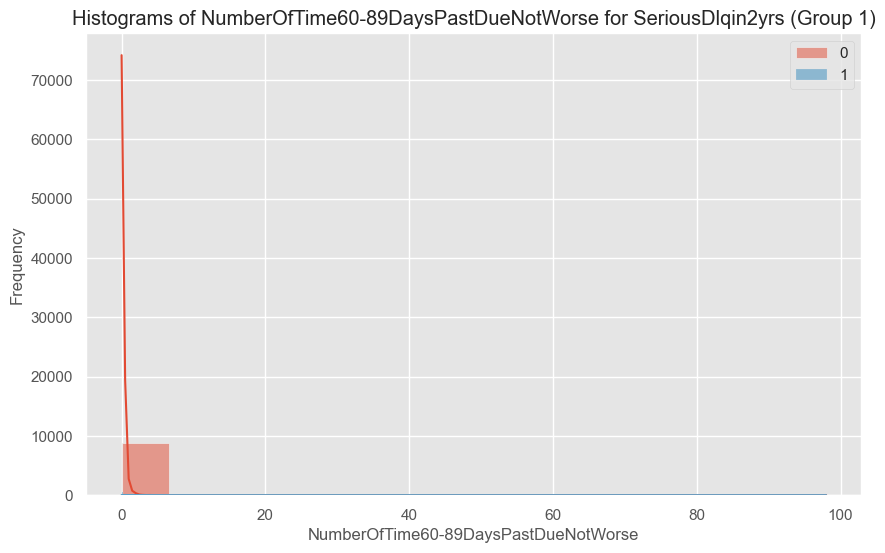

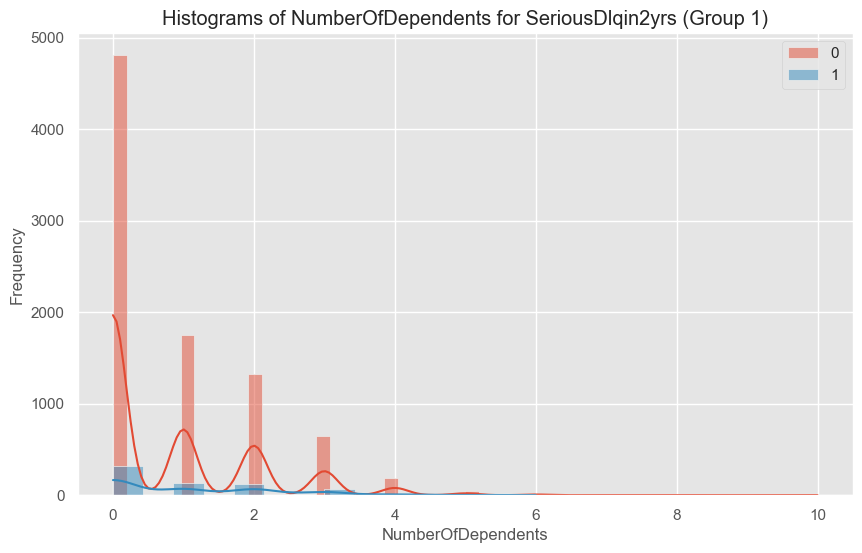

In [64]:
for col in features:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

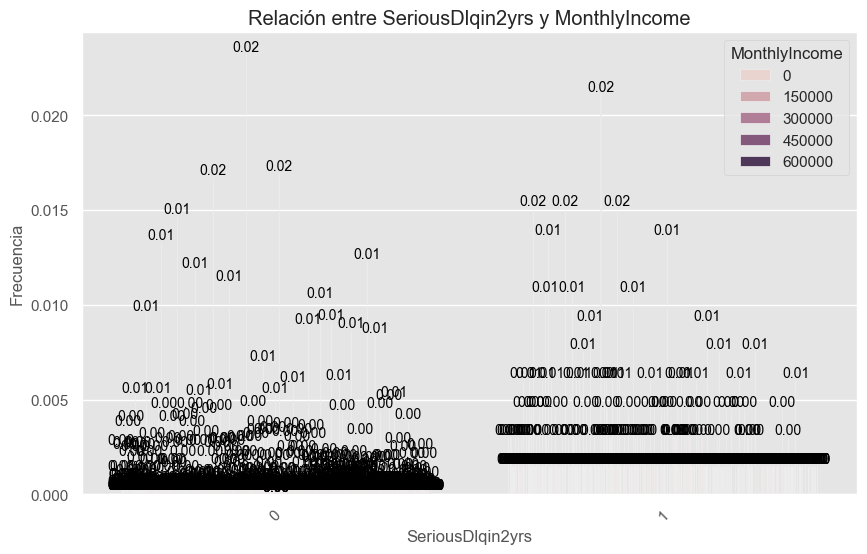

In [65]:
bt.plot_categorical_relationship_fin(train_set, target, "MonthlyIncome", relative_freq= True, show_values= True)

In [66]:
X_train = train_set[features_analysis]
y_train = train_set[target]
X_test = test_set[features_analysis]
y_test = test_set[target]

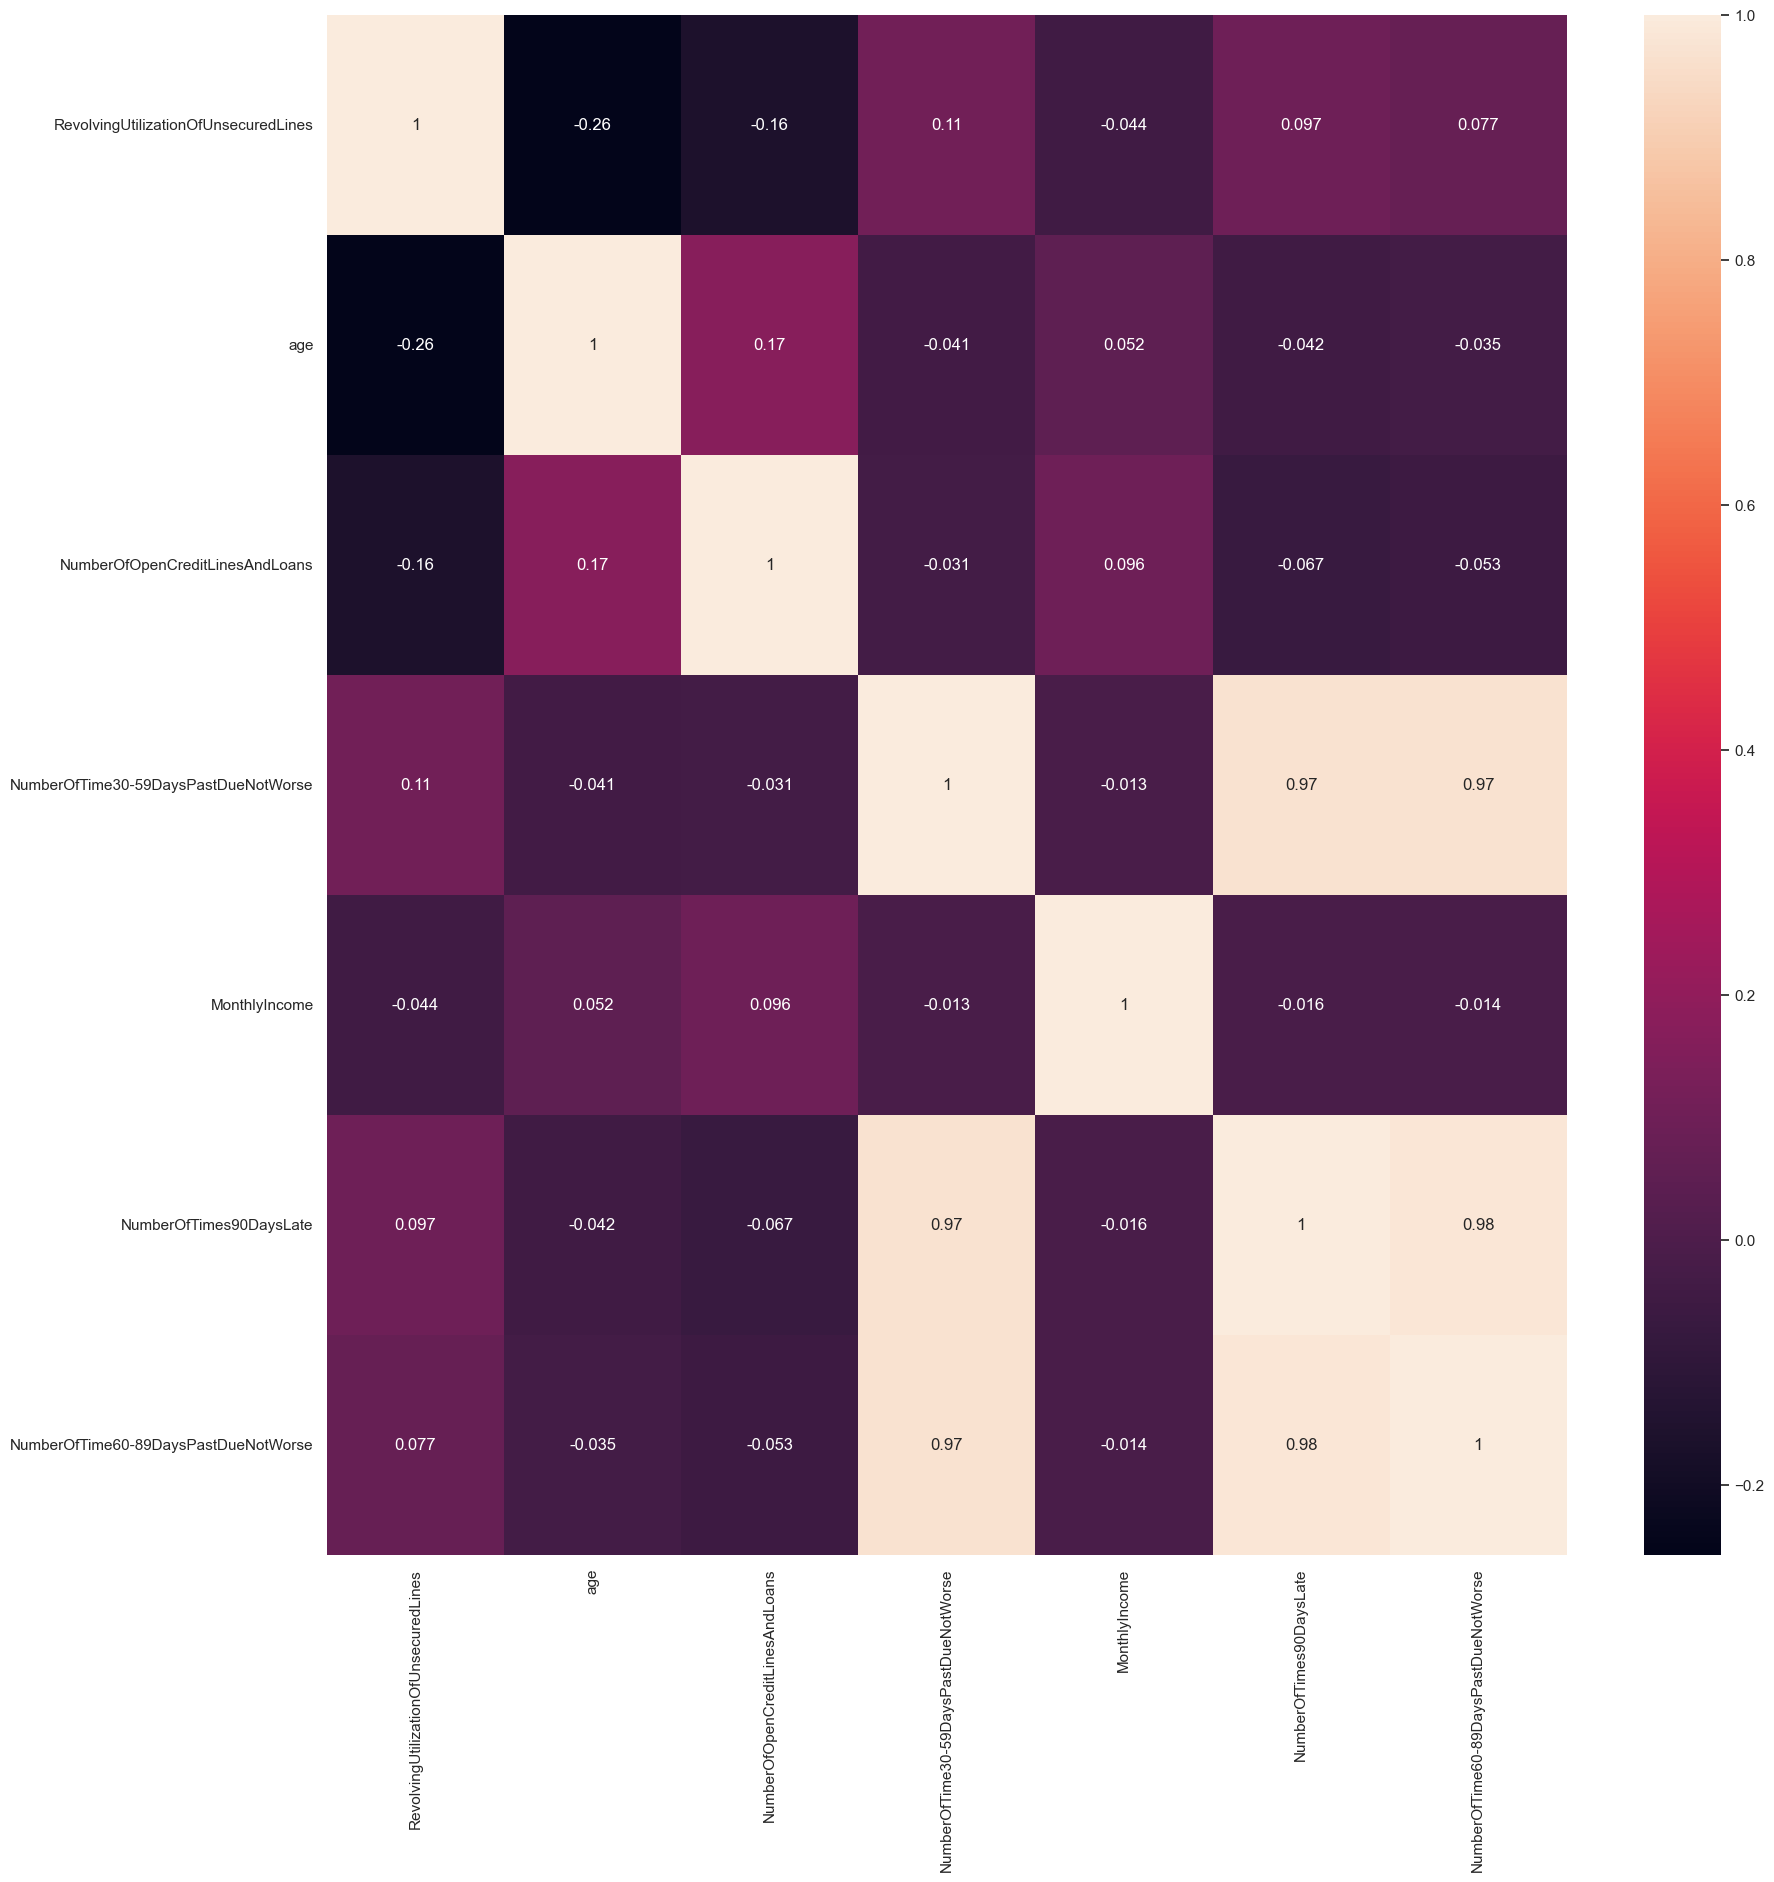

<Figure size 120000x120000 with 0 Axes>

In [67]:
sns.set (rc = {'figure.figsize':(20,20)})
sns.heatmap(X_train.corr(numeric_only=True),annot=True);
plt.figure(figsize=(100, 100), dpi=1200)
plt.show();

In [68]:
tree_rfc = RandomForestClassifier(random_state=42)
tree_rfc.fit(X_train, y_train)
y_pred = tree_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2197
           1       0.52      0.15      0.23       167

    accuracy                           0.93      2364
   macro avg       0.73      0.57      0.60      2364
weighted avg       0.91      0.93      0.91      2364



In [70]:
recall_medio = np.mean(cross_val_score(tree_rfc, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio, " para tree_rfc")

0.5940205777381772 para tree_rfc


In [71]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
print(classification_report(y_train, tree_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8789
           1       1.00      1.00      1.00       663

    accuracy                           1.00      9452
   macro avg       1.00      1.00      1.00      9452
weighted avg       1.00      1.00      1.00      9452



In [72]:
recall_medio = np.mean(cross_val_score(tree_clf, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio, " para tree_clf")

0.6094932776040213  para tree_clf


In [22]:
train_set, test_set = train_test_split(df_credit, test_size= 0.2, random_state= 42)

In [23]:
X_train = train_set[features_analysis]
y_train = train_set[target]
X_test = test_set[features_analysis]
y_test = test_set[target]

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)

X = train_set[features_analysis].copy()
y = train_set[target]

knn.fit(X,y)

KNeighborsClassifier(n_neighbors=4)

In [35]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2197
           1       0.00      0.00      0.00       167

    accuracy                           0.93      2364
   macro avg       0.46      0.50      0.48      2364
weighted avg       0.86      0.93      0.89      2364



In [73]:
recall_medio = np.mean(cross_val_score(knn, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio, " para knn")

0.5171853083336483  para knn


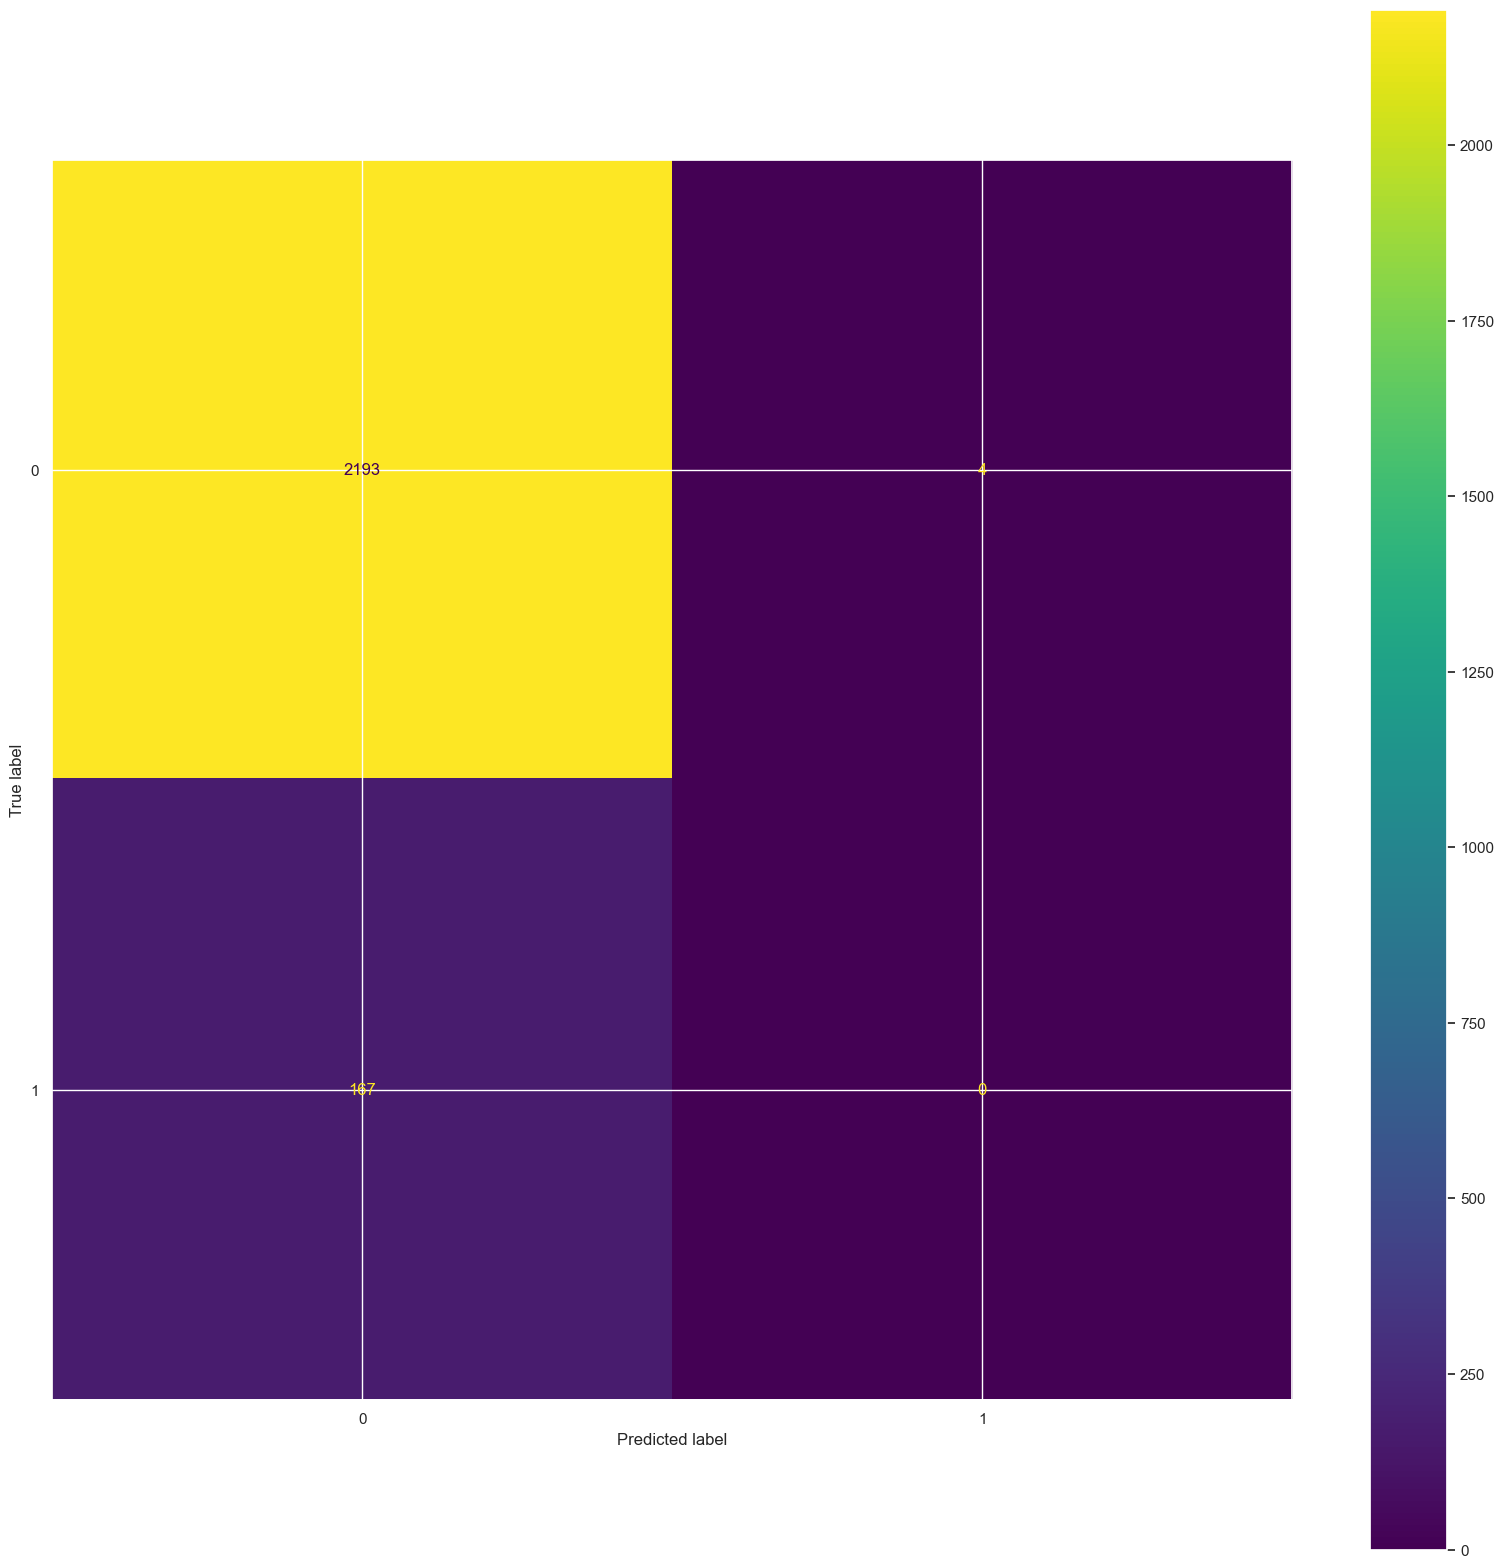

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, knn.predict(X_test))

Escalo las features

In [37]:
minmax= MinMaxScaler()
train_set[features_analysis] = minmax.fit_transform(train_set[features_analysis])
test_set[features_analysis] = minmax.transform(test_set[features_analysis]) # Observa que al igual que hacemos con el StandarScaler el fit sólo es a train y no otra vez a test (sólo usamos transform)
 

In [ ]:
X_train = train_set[features_analysis]
y_train = train_set[target]
X_test = test_set[features_analysis]
y_test = test_set[target]

In [74]:
n_neighbors = 3

knnscaled = KNeighborsClassifier(n_neighbors)
knnscaled.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [75]:
print(classification_report(y_train, knnscaled.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8789
           1       0.76      0.15      0.25       663

    accuracy                           0.94      9452
   macro avg       0.85      0.57      0.61      9452
weighted avg       0.93      0.94      0.92      9452



In [76]:
print(classification_report(y_test, knnscaled.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2197
           1       0.12      0.02      0.04       167

    accuracy                           0.92      2364
   macro avg       0.53      0.51      0.50      2364
weighted avg       0.87      0.92      0.89      2364



In [77]:
recall_medio = np.mean(cross_val_score(knnscaled, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio, " para knnscaled")

0.504449522863741  para knnscaled


In [78]:
metricas = []
for k in range(1,21):
    print(f"Para k= {k}, recall medio:", end = " ")
    model = KNeighborsClassifier(n_neighbors= k)
    balanced_accuracy = np.mean(cross_val_score(model,X_train,y_train, cv = 5, scoring= "balanced_accuracy"))
    metricas.append(balanced_accuracy)
    print(balanced_accuracy)
best_k = np.argmax(metricas) + 1 # Guardo el hiperparámetro óptimo para luego entrenar el mejor modelo
print(f"best_k {best_k}")

Para k= 1, recall medio: 0.5171853083336483
Para k= 2, recall medio: 0.5008001247548537
Para k= 3, recall medio: 0.504449522863741
Para k= 4, recall medio: 0.5008211331668714
Para k= 5, recall medio: 0.5031004055276286
Para k= 6, recall medio: 0.5013956898140479
Para k= 7, recall medio: 0.5018688514646841
Para k= 8, recall medio: 0.5006438101147999
Para k= 9, recall medio: 0.500473161650636
Para k= 10, recall medio: 0.5
Para k= 11, recall medio: 0.49994311717861206
Para k= 12, recall medio: 0.5
Para k= 13, recall medio: 0.5
Para k= 14, recall medio: 0.5
Para k= 15, recall medio: 0.5
Para k= 16, recall medio: 0.5
Para k= 17, recall medio: 0.5
Para k= 18, recall medio: 0.5
Para k= 19, recall medio: 0.5
Para k= 20, recall medio: 0.5
best_k 1


In [79]:
best_model = KNeighborsClassifier(n_neighbors= best_k)
best_model.fit(X_train, y_train)
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2197
           1       0.10      0.09      0.09       167

    accuracy                           0.88      2364
   macro avg       0.51      0.51      0.51      2364
weighted avg       0.87      0.88      0.87      2364



In [80]:
recall_medio = np.mean(cross_val_score(best_model, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio, " para best_model")

0.5171853083336483  para best_model


In [81]:
param_grid = {
    "n_neighbors": range(1,20),
    "weights": ["uniform","distance"]
}

knn_grid = GridSearchCV(knn, 
                        param_grid = param_grid,
                        cv = 5,
                        scoring = "balanced_accuracy")

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=1),
             param_grid={'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [82]:
knn_grid.best_params_

{'n_neighbors': 2, 'weights': 'distance'}

In [83]:
knn_grid.best_score_

0.5172421911550362

In [84]:
print(classification_report(y_test, knn_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2197
           1       0.10      0.09      0.09       167

    accuracy                           0.88      2364
   macro avg       0.51      0.51      0.51      2364
weighted avg       0.87      0.88      0.87      2364



In [85]:
recall_medio = np.mean(cross_val_score(knn_grid, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio, " para knn_grid")

0.5117913355020969  para knn_grid


 tree_clf tiene el mejor recall medio 
 0.6094932776040213
